<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

In [1]:
%run supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



# **BLIP: Bootstrapping Language-Image Pre-Training**

### **Shortcomings of Previous Models**

1. **Noisy Web Data as a Limitation**  
   Previous models, including **CLIP**, rely on large-scale datasets of image-text pairs collected from the web. These datasets often contain noisy captions or alt-texts that fail to describe the associated images accurately. Such noise hinders the model's ability to learn high-quality vision-language representations.

2. **Task-Specific Architectures**  
   Vision-language tasks can be broadly categorized into:
   - **Understanding-based tasks** (e.g., image-text retrieval, classification).
   - **Generation-based tasks** (e.g., image captioning, visual question answering).  
   Encoder-based models (e.g., CLIP) excel at understanding tasks but lack capabilities for text generation. Encoder-decoder models (e.g., SimVLM) perform well at generation tasks but are not optimized for retrieval and understanding tasks. These task-specific architectures lack flexibility and generalizability.

What if

- **We could generate captions for images where none exist?**  
   Imagine a model that looks at a web image and creates a meaningful, accurate caption from scratch—capturing the scene's essence without relying on noisy web text.

- **We could fix noisy captions instead of simply discarding them?**  
   What if a model could refine an imperfect dataset, cleaning it up as part of the training process? Could such a process improve learning while reducing reliance on expensive human-annotated datasets?

- **We could use one model for everything?**  
   What if we didn’t need different architectures for understanding tasks like retrieval and generation tasks like captioning? Could a single model excel at both?

### **Enter BLIP**
BLIP was introduced in the paper [BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation](https://arxiv.org/pdf/2201.12086) in early 2022.
It introduces two major innovations to overcome the limitations of its predecessors:

1. **Captioning and Filtering (CapFilt):**  
   BLIP refines noisy web data by:
   - Using a **captioner** to generate synthetic captions for web images.
   - Employing a **filter** to remove noisy captions, ensuring a cleaner and higher-quality training dataset.  
   This approach bootstraps the dataset, iteratively improving the quality of the image-text pairs.

2. **Multimodal Mixture of Encoder-Decoder (MED):**  
   BLIP leverages a unified model architecture that seamlessly handles both understanding and generation tasks:
   - **Understanding:** Image-text contrastive learning and matching.
   - **Generation:** Image-grounded text generation with fine-grained alignment.  
   By sharing parameters across its encoder and decoder, MED enables efficient multi-task learning and supports diverse downstream tasks.


This notebook will explore BLIP, its architecture, dataset bootstrapping methods, and practical applications in various vision-language tasks, highlighting how it overcomes the challenges faced by previous models.

### **Multimodal Mixture of Encoder-Decoder (MED)**

The architecture of BLIP is built around the **Multimodal Mixture of Encoder-Decoder (MED)**, a unified model capable of handling both vision-language understanding and generation tasks. The MED architecture supports three key functionalities, each trained with a specific loss function tailored to its role.

![blip.png](../images/blip.png)


1. **Unimodal Encoder with Image-Text Contrastive (ITC) Loss (CLIP)**  
   - **Functionality:** The unimodal encoder processes images and text separately to align their representations in a shared feature space.  
   - **ITC Loss:**  
     - Encourages positive image-text pairs (e.g., an image of a cat and the text "a cat") to have similar embeddings.  
     - Pushes apart embeddings of negative pairs (e.g., mismatched image-text pairs).  
   - **Task:** Supports alignment tasks like **image-text retrieval**, where the goal is to find the most relevant image or text based on a query.  

2. **Image-Grounded Text Encoder with Image-Text Matching (ITM) Loss**  
   - **Functionality:** The image-grounded text encoder incorporates visual context into textual representations through cross-attention layers, enabling it to model interactions between images and text.  
   - **ITM Loss:**  
     - Determines whether an image-text pair is matched or unmatched (binary classification).  
     - Uses **hard negative mining** to prioritize learning from challenging mismatched pairs.  

3. **Image-Grounded Text Decoder with Language Modeling (LM) Loss**  
   - **Functionality:** The text decoder generates coherent text sequences (e.g., captions) conditioned on visual inputs. It replaces bi-directional self-attention layers with causal self-attention layers, enabling autoregressive text generation.  
   - **LM Loss:**  
     - Trains the decoder to maximize the likelihood of the correct next word in a sequence, based on image context.  
   - **Task:** Supports generative tasks like **image captioning** and **visual question answering**.  

To learn more about the loss functions of BLIP , refer the section at the bottom of the notebook.

### **CapFilt: Captioning and Filtering for Bootstrapping**

Bootstrapping refers to a self-improvement process where the model iteratively refines its training dataset. In CapFilt, this happens through:

1. **Captioning:**  
   - BLIP’s **Image-Grounded Text Decoder** generates captions for images that either lack captions or have noisy ones.  
   - These synthetic captions are used to supplement or replace existing captions, providing richer and more accurate descriptions.

2. **Filtering:**  
   - BLIP’s **Image-Grounded Text Encoder** evaluates both synthetic and original captions.  
   - The **Image-Text Matching (ITM) Head** predicts whether a given caption matches the image or not.  
   - Low-quality or irrelevant captions (both synthetic and existing) are filtered out, ensuring the dataset retains only high-quality image-text pairs.

![capfilt.png](../images/capfilt.png)

### **Why Bootstrapping Works**

- **Iterative Refinement:**  
   The process is cyclic: the model generates captions, filters the dataset, trains on the refined dataset, and repeats. This iterative approach improves the dataset and the model’s performance over time.

- **Noise Reduction:**  
   By filtering out irrelevant captions, CapFilt reduces the negative impact of noisy web data, a common issue in large-scale pretraining.

- **Dataset Enrichment:**  
   Synthetic captions generated by the decoder often capture fine-grained details not present in existing captions, making the dataset richer and more informative.


## Use Cases

### Image Captioning

Image captioning generates a descriptive sentence for a given image. For example, given an image of a dog playing fetch in the park, the model might generate the caption, "A dog running with a ball in its mouth." This task tests the model's ability to generate coherent and contextually accurate text grounded in visual input.

- **BLIP Component Used:**  
  - The **Image-Grounded Text Decoder** is utilized for generating the answer based on the input image and question.  
  - The multimodal encoder processes the interactions between the image and question, producing a joint representation that the decoder uses to generate the answer.  

- **How It Works in BLIP:**  
  - The image and question are encoded separately by their respective encoders.  
  - The outputs are fused using the multimodal encoder with cross-attention layers.  
  - The decoder autoregressively generates the answer based on this fused representation.

In [2]:
from PIL import Image
from transformers import AutoProcessor, BlipForConditionalGeneration
from svlearn_vlu import config
import torch


model_name = "Salesforce/blip-image-captioning-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps") if torch.backends.mps.is_available() else device
processor = AutoProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Note: The datasets used in this notebook is available on the course portal. A teaching assisstant will help you download and set it up in your config file during the lab session.

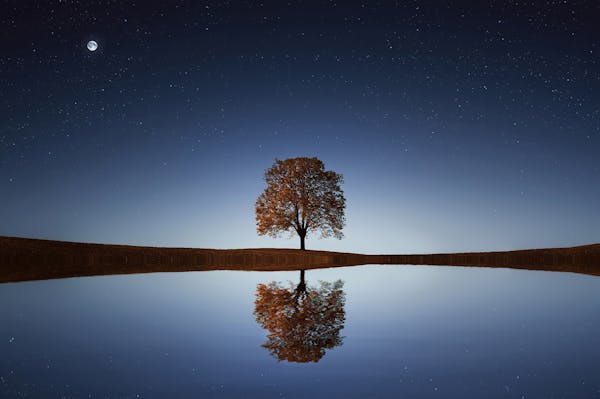

In [3]:
image_path = f"{config['datasets']['trees']}/pexels-photo-268533_1.jpeg"

image = Image.open(fp=image_path)

image

In [4]:
text = "A picture of"

inputs = processor(images=image, text=text, return_tensors="pt").to(device)

outputs = model.generate(**inputs)

outputs
# Decode the generated caption
decoded_output = processor.decode(outputs[0], skip_special_tokens=True)

print("Generated Caption:", decoded_output)


Generated Caption: a picture of a tree in the middle of a lake


In [5]:
text = "A photo of"

inputs = processor(images=image, text=text, return_tensors="pt").to(device)

outputs = model.generate(**inputs)

outputs
# Decode the generated caption
decoded_output = processor.decode(outputs[0], skip_special_tokens=True)

print("Generated Caption:", decoded_output)

Generated Caption: a photo of a tree in the middle of a lake


In [6]:
text = "The sky is"

inputs = processor(images=image, text=text, return_tensors="pt").to(device)

outputs = model.generate(**inputs)

outputs
# Decode the generated caption
decoded_output = processor.decode(outputs[0], skip_special_tokens=True)

print("Generated Caption:", decoded_output)

Generated Caption: the sky is full of stars and a tree in the middle of the image


In [7]:
text = "The moon is"

inputs = processor(images=image, text=text, return_tensors="pt").to(device)

outputs = model.generate(**inputs)

outputs
# Decode the generated caption
decoded_output = processor.decode(outputs[0], skip_special_tokens=True)

print("Generated Caption:", decoded_output)

Generated Caption: the moon is shining over a tree in a lake


In [8]:
text = "A lone tree"

inputs = processor(images=image, text=text, return_tensors="pt").to(device)

outputs = model.generate(**inputs)

outputs
# Decode the generated caption
decoded_output = processor.decode(outputs[0], skip_special_tokens=True)

print("Generated Caption:", decoded_output)

Generated Caption: a lone tree stands in a still still still still still still in the still still still still still still still still still


### Visual Question Answering

VQA is a task where the model answers a natural language question based on the content of an image. For instance, given an image of a park and the question, "What is the child holding?" the model should generate the answer, "A balloon." VQA tests the model's ability to understand both visual content and textual queries, requiring fine-grained reasoning over the image.

- **BLIP Component Used:**  
  - The **Image-Grounded Text Decoder** is utilized for generating the answer based on the input image and question.  
  - The multimodal encoder processes the interactions between the image and question, producing a joint representation that the decoder uses to generate the answer.  

- **How It Works in BLIP:**  
  - The image and question are encoded separately by their respective encoders.  
  - The outputs are fused using the multimodal encoder with cross-attention layers.  
  - The decoder autoregressively generates the answer based on this fused representation.

In [9]:
from transformers import AutoProcessor, BlipForQuestionAnswering

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

In [10]:
text = "What is the subject of the picture?"
inputs = processor(images=image, text=text, return_tensors="pt")
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))

tree


In [11]:
text = "What time of day is the picture taken?"
inputs = processor(images=image, text=text, return_tensors="pt")
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))

night


In [12]:
text = "Which phase of the moon is seen?"
inputs = processor(images=image, text=text, return_tensors="pt")
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))

full


In [13]:
text = "What feeling does this image convey?"
inputs = processor(images=image, text=text, return_tensors="pt")
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))

calm


In [14]:
text = "What should a child be careful of near this?"
inputs = processor(images=image, text=text, return_tensors="pt")
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))

water


From these examples we can see that the model has really understood the subtext of the image.  While the model can anwer these questions, it is not as descriptive as we would like. We will see in the next notebook on BLIP-2 where visual question answering performance is significantly improved.

We have captioned a set of images handpicked from unsplash using blip. The code can be found in `svlearn/blip/captioner.py`. Run this file before running the next cell. We will use this dataset to compare the performance of BLIP with other models in the upcoming notebook.

Image,Caption
,BLIP: a photo of a view of a river
,BLIP: a photo of a dog and a cat
,BLIP: a photo of a group of fish with their mouths open
,BLIP: a photo of a horse sticking its head out of a barn
,BLIP: a photo of two carved pumpkins on a plate
,BLIP: a photo of a yellow dough with a smiley face
,BLIP: a photo of a sign in the woods
,BLIP: a photo of a man riding a bike on a city street
,BLIP: a photo of a hand with a x - ray
,BLIP: a photo of a person on a surfboard in the sand

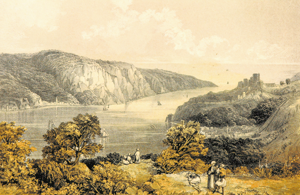
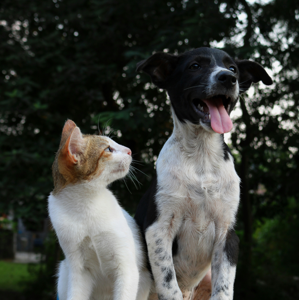
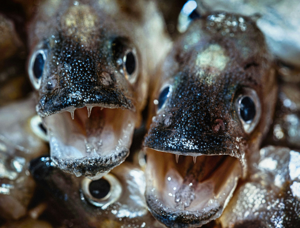
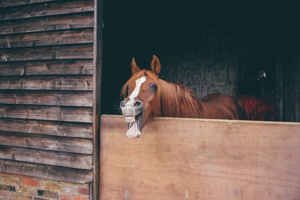
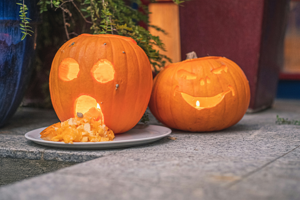
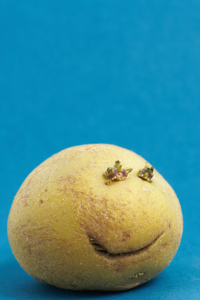
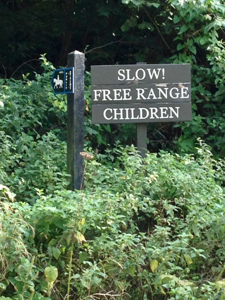
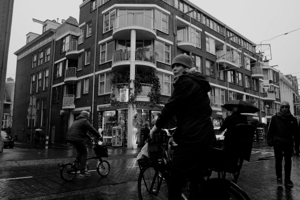
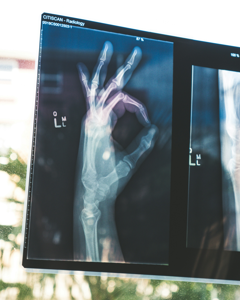
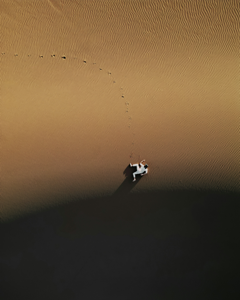
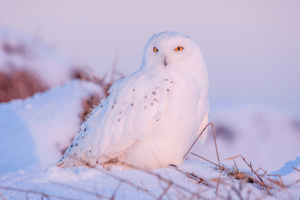
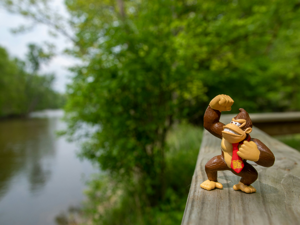
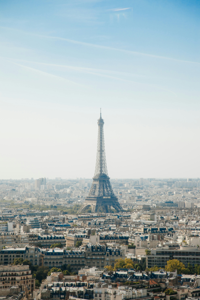
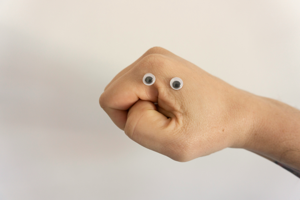
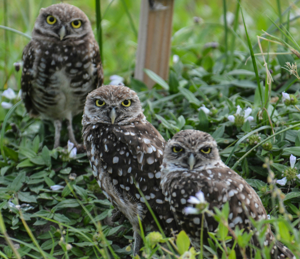
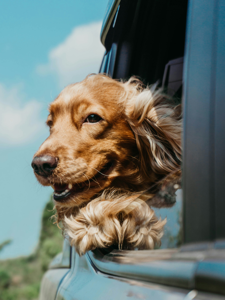
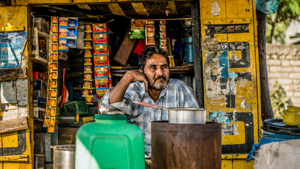
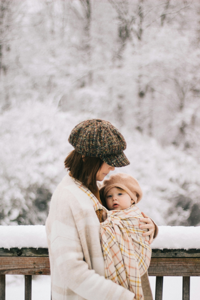
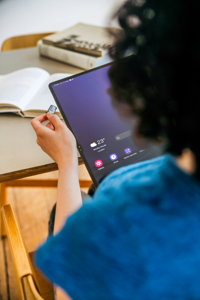
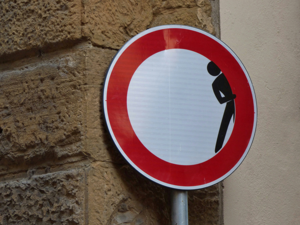
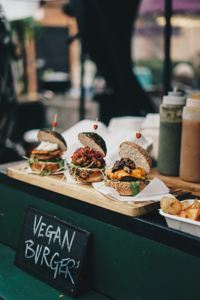
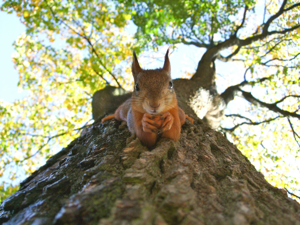
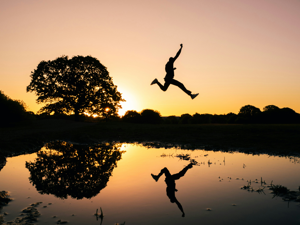
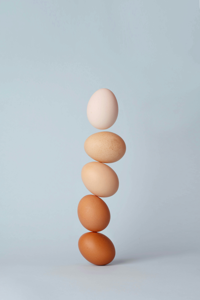
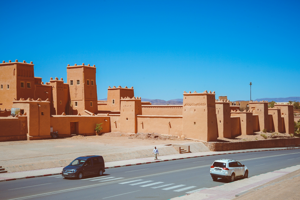

In [15]:
from svlearn_vlu.utils.display_captions_table import CaptionDisplay

image_dir = config['datasets']["unsplash"]
captions_file = f"{image_dir}/captions.json"

caption_display = CaptionDisplay(image_dir, captions_file)
caption_display.display(num_samples=25, model_names=['blip'])

## **Loss functions of BLIP**

#### **Cross-Entropy Loss: A Refresher**

The cross-entropy loss, denoted as $H$, measures the difference between the ground truth distribution $y$ (one-hot encoded) and the predicted distribution $p$ (softmax probabilities). For a single prediction, it is computed as:  
$$
\begin{equation}
H(y, p) = - \sum_{i} y_i \log(p_i)
\end{equation}
$$  
Where:  
- $y_i$ is the ground truth probability for class $i$, typically 1 for the correct class and 0 for others in a one-hot encoded vector.  
- $p_i$ is the predicted probability for class $i$.  

For a one-hot ground truth, where $y_k = 1$ for the correct class $k$:  
$$
\begin{equation}
H(y, p) = - \log(p_k)
\end{equation}
$$  



### **Image-Text Contrastive (ITC) Loss**

#### **Bringing Embeddings to a Common Dimension**

The image and text embeddings from the unimodal encoders, denoted as $\mathbf{f}_{I}$ (for the image's [CLS] token) and $\mathbf{f}_{T}$ (for the text's [CLS] token), are initially in different feature spaces. To align them, they are projected into a common lower-dimensional space using learned linear transformation functions $g_{I}$ and $g_{T}$:  
$$
\begin{equation}
\mathbf{z}_{I} = g_{I}(\mathbf{f}_{I}), \quad \mathbf{z}_{T} = g_{T}(\mathbf{f}_{T})
\end{equation}
$$  
Where $\mathbf{z}_{I}$ and $\mathbf{z}_{T}$ are the resulting lower-dimensional embeddings.


#### **Computing Similarity**

The similarity $s(I, T)$ between an image $I$ and text $T$ is the dot product of their normalized embeddings:  
$$
\begin{equation}
s(I, T) = \frac{\mathbf{z}_{I} \cdot \mathbf{z}_{T}}{\|\mathbf{z}_{I}\| \|\mathbf{z}_{T}\|}
\end{equation}
$$  
This similarity score measures how closely the image and text embeddings align in the shared space.


#### **Probabilities for Positive and Negative Pairs**

The probability of matching a given image $I$ with a text $T_m$ is computed using a softmax function over all candidate text embeddings in the batch (or a maintained queue):  
$$
\begin{equation}
p^{i2t}_{m}(I) = \frac{\exp(s(I, T_m) / \tau)}{\sum_{m=1}^M \exp(s(I, T_m) / \tau)}
\end{equation}
$$  
Similarly, the probability of matching a text $T$ with an image $I_m$ is:  
$$
\begin{equation}
p^{t2i}_{m}(I)  = \frac{\exp(s(T, I_m) / \tau)}{\sum_{m=1}^M \exp(s(T, I_m) / \tau)}
\end{equation}
$$  
Where:  
- $\tau$ is a learnable temperature parameter that controls the sharpness of the probability distribution.  
- $M$ is the number of candidate pairs in the batch or queue.



#### **Piecing together the ITC Loss**

The ITC loss ensures positive image-text pairs have high similarity while pushing negative pairs apart. It is defined as the average (or sum) of two cross-entropy losses (for image-to-text and text-to-image):  
$$
L_{ITC} = - \frac{1}{2} \mathbb{E}_{(I, T)} \Big[ H(\mathbf{y}^{i2t}(I), \mathbf{p}^{i2t}(I)) + H(\mathbf{y}^{t2i}(I), \mathbf{p}^{t2i}(I)) \Big]
$$  
Where:  
- $\mathbf{y}^{i2t}(I)$ and $\mathbf{y}^{t2i}(I)$ are one-hot ground truth labels indicating the correct image-text pair.  

This loss function encourages the embeddings of positive pairs to align closely in the shared space while ensuring negative pairs are far apart, creating a strong foundation for downstream tasks like retrieval.

### **Image-Text Matching (ITM) Loss**

The Image-Text Matching (ITM) loss enables the model to reason about whether a given image-text pair matches (positive) or does not match (negative). It focuses on fine-grained alignment and interaction between modalities after they are fused in the multimodal encoder.


#### **Fusing Image and Text Embeddings**

The unimodal embeddings $\mathbf{f}_{I}$ (from the image encoder) and $\mathbf{f}_{T}$ (from the text encoder) are fused using the **multimodal encoder**. The multimodal encoder incorporates cross-attention layers, enabling interactions between image and text features. 

After processing, a shared [CLS] token embedding, $\textbf{h}_{\text{cls}}$, is produced to represent the joint representation of the image-text pair.


#### **Predicting Matching Probability**

The joint [CLS] embedding $\textbf{h}_{\text{cls}}$ is passed through a fully connected (FC) layer followed by a softmax function to predict whether the image-text pair matches or not:  
$$
\mathbf{p}^{\text{itm}} = \text{softmax}(\textbf{W} \cdot \textbf{h}_{\text{cls}})
$$  
Where:  
- $\textbf{W}$ is the learned weight matrix of the FC layer.  
- $\mathbf{p}^{\text{itm}}$ is a two-dimensional probability vector for the "matched" and "not matched" classes.


#### **Ground-Truth Labels**

For each image-text pair:  
- Positive pairs are labeled as 1 (matched).  
- Negative pairs are labeled as 0 (not matched).  

The ground-truth label is represented as a one-hot vector $\mathbf{y}^{\text{itm}}$, where:  
$$
\mathbf{y}^{\text{itm}} = [1, 0] \quad \text{(for matched pairs)}, \quad \mathbf{y}^{\text{itm}} = [0, 1] \quad \text{(for unmatched pairs)}
$$


#### **Step 4: Hard Negative Mining**

- Hard negatives are mismatched image-text pairs that are semantically similar but not true matches (e.g., an image of a dog paired with the caption "a cat sitting on a couch").  
- These pairs are identified using the similarity scores computed by the **ITC loss**. They are prioritized during training to improve the model's ability to handle fine-grained mismatches.


#### **Piecing together the ITM loss**

The ITM loss is a **binary cross-entropy loss** that compares the predicted probabilities $\mathbf{p}^{\text{itm}}$ with the ground truth $\mathbf{y}^{\text{itm}}$:  
$$
L_{ITM} = \mathbb{E}_{(I, T)} \big[ H(\mathbf{y}^{\text{itm}}, \mathbf{p}^{\text{itm}}) \big]
$$  
Where:  
- $H(y, p)$ is the cross-entropy function (as explained earlier).  
- $\mathbf{p}^{\text{itm}}$ is the predicted probability vector.  
- $\mathbf{y}^{\text{itm}}$ is the one-hot encoded ground truth label.

### **Language Modeling (LM) Loss**

The **Language Modeling (LM) Loss** is used in BLIP for tasks that involve **text generation**, such as image captioning and visual question answering. This loss trains the **Image-Grounded Text Decoder** to predict the next word in a sequence, conditioned on both the image and the preceding words.


#### **Input to the Decoder:**  
   - The decoder receives the visual context from the image encoder through the multimodal encoder.  
   - It also takes the textual input, where a portion of the sequence is provided as context, and the next token in the sequence is masked (to be predicted).

#### **Autoregressive Prediction:**  
   - The decoder generates text one token at a time.  
   - Each prediction is conditioned on the image features and the tokens generated so far.

#### **Cross-Entropy Loss for Word Prediction:**  
   - For a given masked token $y_t$ in the sequence, the decoder predicts a probability distribution $p_t$ over the vocabulary.  
   - The loss for a single token is the **cross-entropy** between the true token $y_t$ (one-hot encoded) and the predicted probability distribution $p_t$:
Here’s the correction with detailed notation:
   In the equation for the **cross-entropy loss**:  
   $$
   H(y_t, p_t) = - \sum_{i} y_{t, i} \log(p_{t, i})
   $$  

   - $y_t$: The one-hot encoded ground truth vector for the token at position $t$.  
   - $p_t$: The predicted probability distribution over the vocabulary at position $t$.  
   - $i$: Index representing each token in the vocabulary.  For example, if the vocabulary has 10,000 tokens, $i$ ranges from $1$ to $10,000$.  
   - $y_{t, i}$: The ground truth probability for token $i$ at position $t$ (1 for the correct token, 0 for others).  
   - $p_{t, i}$: The predicted probability for token $i$ at position $t$.

   When $y_t$ is one-hot, only the correct token $k$ has $y_{t, k} = 1$, so the summation reduces to:  
   $$
   H(y_t, p_t) = - \log(p_{t, k})
   $$  

   This ensures the loss only penalizes the model based on the predicted probability of the correct token.

#### **LM Loss for the Entire Sequence:**  
   - The loss is averaged over all predicted tokens in the sequence:
     $$
     L_{LM} = \frac{1}{T} \sum_{t=1}^{T} H(y_t, p_t)
     $$
     Where:
     - $T$ is the total number of tokens in the sequence.  
     - $y_t$ is the ground truth token at position $t$.  
     - $p_t$ is the predicted probability distribution at position $t$.


## References

- [Align before Fuse: Vision and Language Representation Learning with Momentum Distillation](https://arxiv.org/pdf/2107.07651)
- [BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation](https://arxiv.org/pdf/2201.12086)